In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())


batch_size = 100
n_iters = 3000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [8]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

input_dim = 28*28
output_dim = 10

model = LogisticRegressionModel(input_dim, output_dim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.001
weight_decay=0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


In [9]:
iter = 0
cont = True
epsilon = 0.01
d_loss=[0,0]
epoch=0
while cont:
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).requires_grad_().to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % int(len(train_dataset)/batch_size) == 0:
        
            correct = 0
            total = 0

            for images, labels in test_loader:

                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            print('epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))
    d_loss[0] = d_loss[1]
    d_loss[1] = accuracy
    
    if abs(d_loss[1]-d_loss[0]) < epsilon:
       
      correct = 0
      total = 0
      mpred=[]
      mlabel=[]

      for images, labels in test_loader:

          images = images.view(-1, 28*28).to(device)

          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)

          mlabel.append(labels.numpy())
          mpred.append(predicted.numpy())

          total += labels.size(0)

          if torch.cuda.is_available():
              correct += (predicted.cpu() == labels.cpu()).sum()
          else:
              correct += (predicted == labels).sum()

      accuracy = 100 * correct.item() / total
      cont=False
    
    epoch +=1


print('epoch: {}. Loss: {}. Accuracy: {}'.format(epoch, loss.item(), accuracy))


epoch: 0. Loss: 1.7762019634246826. Accuracy: 69.4
epoch: 1. Loss: 1.523005723953247. Accuracy: 77.15
epoch: 2. Loss: 1.3356413841247559. Accuracy: 79.6
epoch: 3. Loss: 1.0709837675094604. Accuracy: 81.33
epoch: 4. Loss: 1.0264317989349365. Accuracy: 82.52
epoch: 5. Loss: 0.9881714582443237. Accuracy: 83.29
epoch: 6. Loss: 0.9037086367607117. Accuracy: 84.05
epoch: 7. Loss: 0.8035401105880737. Accuracy: 84.38
epoch: 8. Loss: 0.8294628858566284. Accuracy: 84.91
epoch: 9. Loss: 0.7092912197113037. Accuracy: 85.27
epoch: 10. Loss: 0.7043972611427307. Accuracy: 85.57
epoch: 11. Loss: 0.7465556263923645. Accuracy: 85.84
epoch: 12. Loss: 0.7036525011062622. Accuracy: 86.18
epoch: 13. Loss: 0.7133787274360657. Accuracy: 86.46
epoch: 14. Loss: 0.5194815993309021. Accuracy: 86.74
epoch: 15. Loss: 0.6105207204818726. Accuracy: 86.86
epoch: 16. Loss: 0.5859789848327637. Accuracy: 86.95
epoch: 17. Loss: 0.714191734790802. Accuracy: 87.14
epoch: 18. Loss: 0.6189153790473938. Accuracy: 87.31
epoch: 

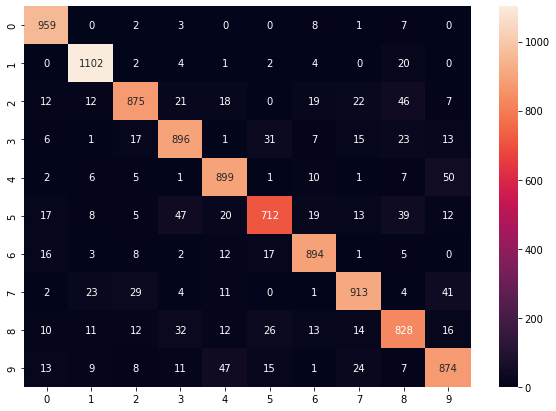

In [11]:
array = confusion_matrix(np.asarray(mlabel).flatten(),np.asarray(mpred).flatten())
df_cm = pd.DataFrame(array, index = [i
      for i in "0123456789"
   ],
   columns = [i
      for i in "0123456789"
   ])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, annot = True,fmt='g')